# References
- https://www.tensorflow.org/recommenders/examples/basic_retrieval
- https://www.tensorflow.org/recommenders/examples/basic_ranking

# Initial Imports

In [1]:
%pip install -q tensorflow-recommenders


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from typing import Dict, Text

import pandas as pd
import numpy as np
import tensorflow as tf
import random

import tensorflow_recommenders as tfrs

import matplotlib.pyplot as plt
import itertools
import seaborn as sns

# Loading Data

In [3]:
events_csv_path = '../events.csv'
ratings_csv_path = '../ratings.csv'
key='9aadb790'
user_count=1000
generate_count=1000
event_count=400

ratings_df = pd.read_csv(f"https://my.api.mockaroo.com/rating.json?key={key}&count={generate_count}&user_id={user_count}&event_id={event_count}")

# drop duplicated
duplicated_series = ratings_df.duplicated(subset=['user_id', 'event_id'], keep=False)
for row in range(0,len(duplicated_series)):
    if duplicated_series[row] == True:
        ratings_df.drop(index=row, inplace=True)

ratings_df.reset_index(drop=True, inplace=True)

# check for duplicated
duplicated_series = ratings_df.duplicated(subset=['user_id', 'event_id'], keep=False)
for row in range(0,len(duplicated_series)):
    if duplicated_series[row] == True:
        print(row)


ratings_df.to_csv(ratings_csv_path, sep=',', encoding='utf-8', index=False)
ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df))

In [4]:
events_df = pd.read_csv(events_csv_path)

non_numeric_cols = events_df.select_dtypes(exclude=['int64', 'float64', 'string']).columns
events_df[non_numeric_cols] = events_df[non_numeric_cols].astype(str)
events_df['interested'] = events_df['interested'].fillna(0).astype(int)

events = tf.data.Dataset.from_tensor_slices(dict(events_df))

In [5]:
print(ratings_df.info(verbose=True))
print(events_df.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994 entries, 0 to 993
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      994 non-null    int64
 1   user_rating  994 non-null    int64
 2   event_id     994 non-null    int64
dtypes: int64(3)
memory usage: 23.4 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           400 non-null    int64 
 1   date         400 non-null    object
 2   event_name   400 non-null    object
 3   location     400 non-null    object
 4   description  400 non-null    object
 5   tags         400 non-null    object
 6   interested   400 non-null    int32 
dtypes: int32(1), int64(1), object(5)
memory usage: 20.4+ KB
None


In [6]:
ratings_df.head(3)

,user_id,user_rating,event_id
0,210,5,104
1,105,3,61
2,975,2,242


In [7]:
events_df.head(3)

,id,date,event_name,location,description,tags,interested
0,1,"Wed, 24 - Fri, 26 May 2023",Tyre & Rubber Indonesia,Jakarta,The Tyre & Rubber Indonesia is the only dedica...,"Tradeshow, Auto & Automotive, Rubber & Tyres",304
1,2,"Wed, 24 - Fri, 26 May 2023","Indonesia International Construction, Infrastr...",Jakarta,Con-Mine â€“ GET your ultimate business chance...,"Tradeshow, Building & Construction",102
2,3,"Sun, 11 - Wed, 14 Jun 2023",ICM Triennial Congress,Bali,It will be six years since our last in-person ...,"Conference, Medical & Pharma, Investment",35


In [8]:
processed_df = pd.merge(ratings_df, events_df, left_on='event_id', right_on='id')
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994 entries, 0 to 993
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      994 non-null    int64 
 1   user_rating  994 non-null    int64 
 2   event_id     994 non-null    int64 
 3   id           994 non-null    int64 
 4   date         994 non-null    object
 5   event_name   994 non-null    object
 6   location     994 non-null    object
 7   description  994 non-null    object
 8   tags         994 non-null    object
 9   interested   994 non-null    int32 
dtypes: int32(1), int64(4), object(5)
memory usage: 73.9+ KB


In [10]:
processed_df = pd.merge(ratings_df, events_df, left_on='event_id', right_on='id')
location_df = pd.get_dummies(processed_df['location'])
location_df.rename(columns=lambda x: f'location_{x}'.lower().replace(' ', '_'), inplace=True)
# query tower: user_id
# candidate tower: event_id
# x: name, locations, tags, interested
# y: user_rating
processed_df = processed_df.drop(['id','date','description','location'],axis=1)
processed_df = pd.concat([processed_df, location_df],axis=1)
processed_df.head(3)

,user_id,user_rating,event_id,event_name,tags,interested,location_andir,location_bali,location_balikpapan,location_balikpapan_kota,...,location_sukasari,location_sumbersari,location_surabaya,location_surakarta,location_tangerang,location_tegalsari,location_ubud,location_west_denpasar,location_west_semarang,location_yogyakarta
0,210,5,104,EXPO LAUNDRY - Indonesia International Textile...,"Tradeshow, Apparel & Clothing, Household Consu...",288,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,105,3,61,JIFHEX Indonesia,"Tradeshow, Food & Beverages, Hospitality",41,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,159,4,61,JIFHEX Indonesia,"Tradeshow, Food & Beverages, Hospitality",41,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [33]:
ratings = tf.data.Dataset.from_tensor_slices(dict(processed_df))
events = tf.data.Dataset.from_tensor_slices(dict(processed_df)).map(lambda x: x["event_id"])

In [34]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)
n = tf.data.experimental.cardinality(shuffled)

train = shuffled.take(int(n*4/5))
test = shuffled.skip(int(n*4/5)).take(int(n*1/5))
cached_train = train.shuffle(100_000).batch(8192)
cached_test = test.batch(4096)

In [35]:
event_names = events.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_event_ids = np.unique(np.concatenate(list(event_names)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

print(unique_event_ids[:5])
print(unique_user_ids[:5])

[1 2 3 4 5]
[1 2 3 5 7]


# Creating Models

## Retrieval Model

In [36]:
class RetrievalModel(tfrs.Model):
  embedding_dimension = 32
  def __init__(self):
    super().__init__()
    self.event_model: tf.keras.Model = tf.keras.Sequential([
        tf.keras.layers.IntegerLookup(vocabulary=unique_event_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_event_ids) + 1, self.embedding_dimension)
    ])
    self.user_model: tf.keras.Model = tf.keras.Sequential([
        tf.keras.layers.IntegerLookup(vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, self.embedding_dimension)
    ])

    self.task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
      metrics = tfrs.metrics.FactorizedTopK(
        candidates=events.batch(128).map(self.event_model)
      ))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    user_embeddings = self.user_model(features["user_id"])
    positive_event_embeddings = self.event_model(features["event_id"])

    # parameter: query embedding, candidate embedding.
    return self.task(user_embeddings, positive_event_embeddings)

## Ranking Model

In [37]:
class RankingModel(tf.keras.Model):
  embedding_dimension = 32
  def __init__(self):
    super().__init__()
    self.user_embeddings = tf.keras.Sequential([
        tf.keras.layers.IntegerLookup(vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, self.embedding_dimension)
    ])
    self.event_embeddings = tf.keras.Sequential([
        tf.keras.layers.IntegerLookup(vocabulary=unique_event_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_event_ids) + 1, self.embedding_dimension)
    ])

    self.ratings = tf.keras.Sequential([
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      tf.keras.layers.Dense(1)
    ])
  
  def call(self, inputs):
    user_id, event_id = inputs

    user_embedding = self.user_embeddings(user_id)
    event_embedding = self.event_embeddings(event_id)

    # predict rating that the user would give to the event
    return self.ratings(tf.concat([user_embedding, event_embedding], axis=1))

class EventModel(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      loss = tf.keras.losses.MeanSquaredError(),
      metrics=[
        tf.keras.metrics.RootMeanSquaredError(),
        tf.keras.metrics.Accuracy(),
        ],
    )

  # Call what model to use when making prediction
  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model(
        (features["user_id"], features["event_id"]))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # pop rating as the target label
    labels = features.pop("user_rating")
    
    rating_predictions = self(features)

    # The task computes the loss and the metrics.
    return self.task(labels=labels, predictions=rating_predictions)

# Model Fitting, Evaluating, Predicting

## Retrieval Model

### Fitting and evaluating

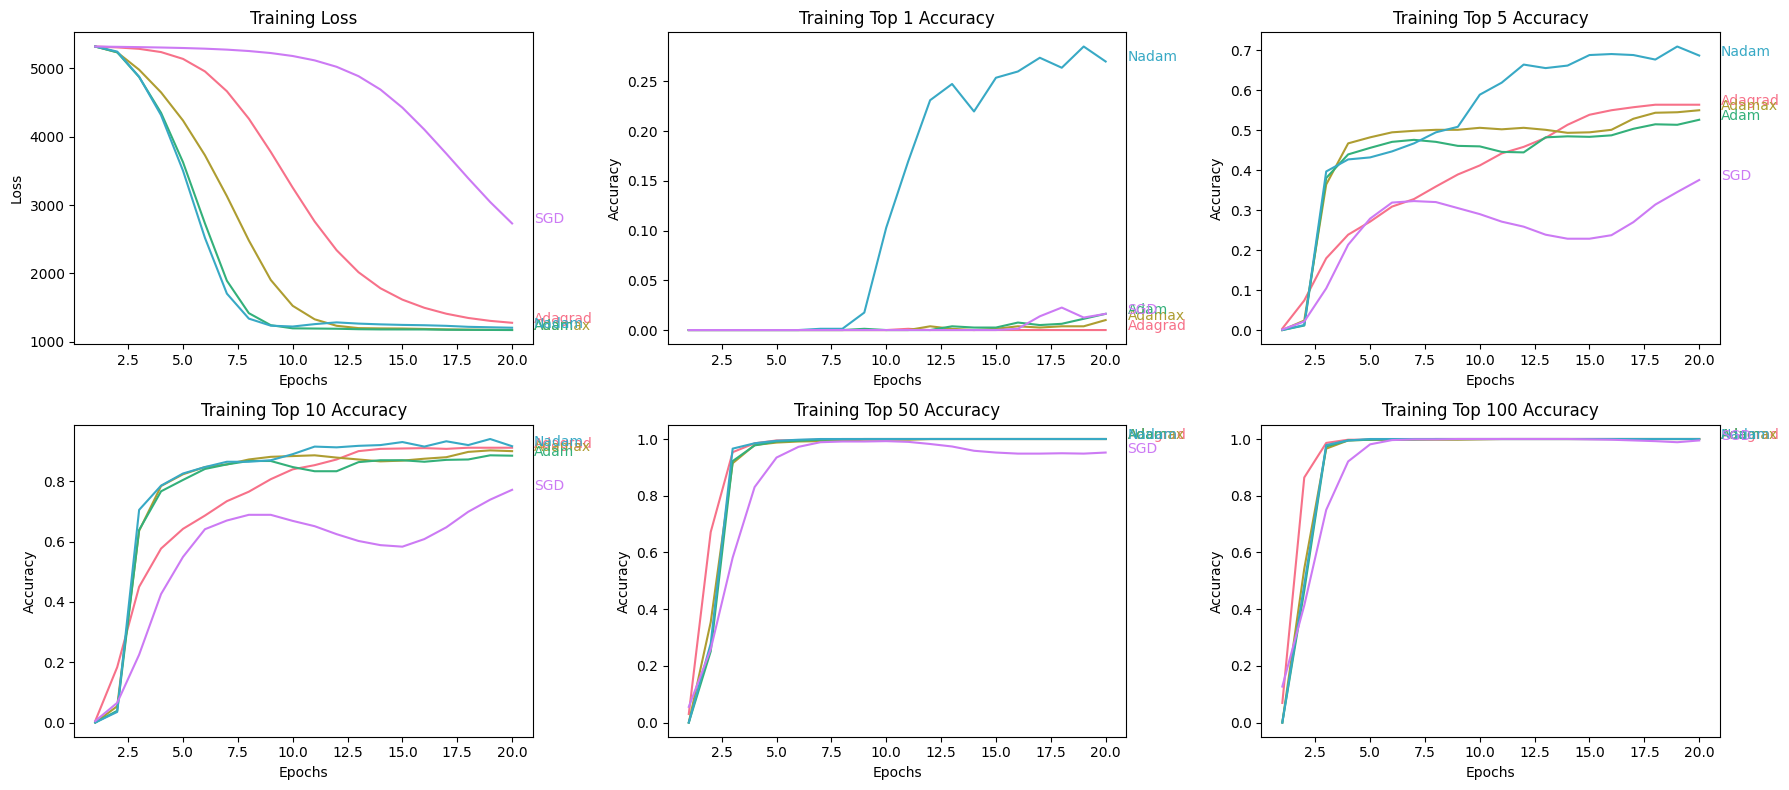

In [38]:
optimizers = [
        tf.keras.optimizers.Adagrad,
        tf.keras.optimizers.Adamax,
        tf.keras.optimizers.Adam,
        tf.keras.optimizers.Nadam,
        tf.keras.optimizers.SGD,
    ]
colors = sns.color_palette('husl', len(optimizers))
plt.figure(figsize=(6*3, 4*2))
for (optimizer, color) in zip(optimizers, colors):
    retrieval_model = RetrievalModel()
    retrieval_model.compile(optimizer=optimizer(learning_rate=0.1))

    history = retrieval_model.fit(cached_train, validation_data=cached_test, epochs=20, verbose=0)

    # Retrieve the training metrics and validation metrics
    train_loss = history.history['loss']
    train_top_1 = history.history['factorized_top_k/top_1_categorical_accuracy']
    train_top_5 = history.history['factorized_top_k/top_5_categorical_accuracy']
    train_top_10 = history.history['factorized_top_k/top_10_categorical_accuracy']
    train_top_50 = history.history['factorized_top_k/top_50_categorical_accuracy']
    train_top_100 = history.history['factorized_top_k/top_100_categorical_accuracy']

    # Plotting the metrics
    epochs = range(1, len(train_loss) + 1)

    # Plotting the loss metrics
    plt.subplot(2, 3, 1)
    plt.plot(epochs, train_loss, color=color)
    plt.title(f'Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.annotate(optimizer().name, xy=(epochs[-1], train_loss[-1]), xytext=(epochs[-1] + 1, train_loss[-1]), color=color)

    # Plotting the accuracy metrics
    plt.subplot(2, 3, 2)
    plt.plot(epochs, train_top_1, color=color)
    plt.title(f'Training Top 1 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.annotate(optimizer().name, xy=(epochs[-1], train_top_1[-1]), xytext=(epochs[-1] + 1, train_top_1[-1]), color=color)

    # Plotting the accuracy metrics
    plt.subplot(2, 3, 3)
    plt.plot(epochs, train_top_5, color=color)
    plt.title(f'Training Top 5 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.annotate(optimizer().name, xy=(epochs[-1], train_top_5[-1]), xytext=(epochs[-1] + 1, train_top_5[-1]), color=color)

    # Plotting the accuracy metrics
    plt.subplot(2, 3, 4)
    plt.plot(epochs, train_top_10, color=color)
    plt.title(f'Training Top 10 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.annotate(optimizer().name, xy=(epochs[-1], train_top_10[-1]), xytext=(epochs[-1] + 1, train_top_10[-1]), color=color)

    # Plotting the accuracy metrics
    plt.subplot(2, 3, 5)
    plt.plot(epochs, train_top_50, color=color)
    plt.title(f'Training Top 50 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.annotate(optimizer().name, xy=(epochs[-1], train_top_50[-1]), xytext=(epochs[-1] + 1, train_top_50[-1]), color=color)

    # Plotting the accuracy metrics
    plt.subplot(2, 3, 6)
    plt.plot(epochs, train_top_100, color=color)
    plt.title(f'Training Top 100 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.annotate(optimizer().name, xy=(epochs[-1], train_top_100[-1]), xytext=(epochs[-1] + 1, train_top_100[-1]), color=color)
    # Display the plot

    plt.tight_layout()
plt.show()

### We pick Nadam as one of the better achieving models.

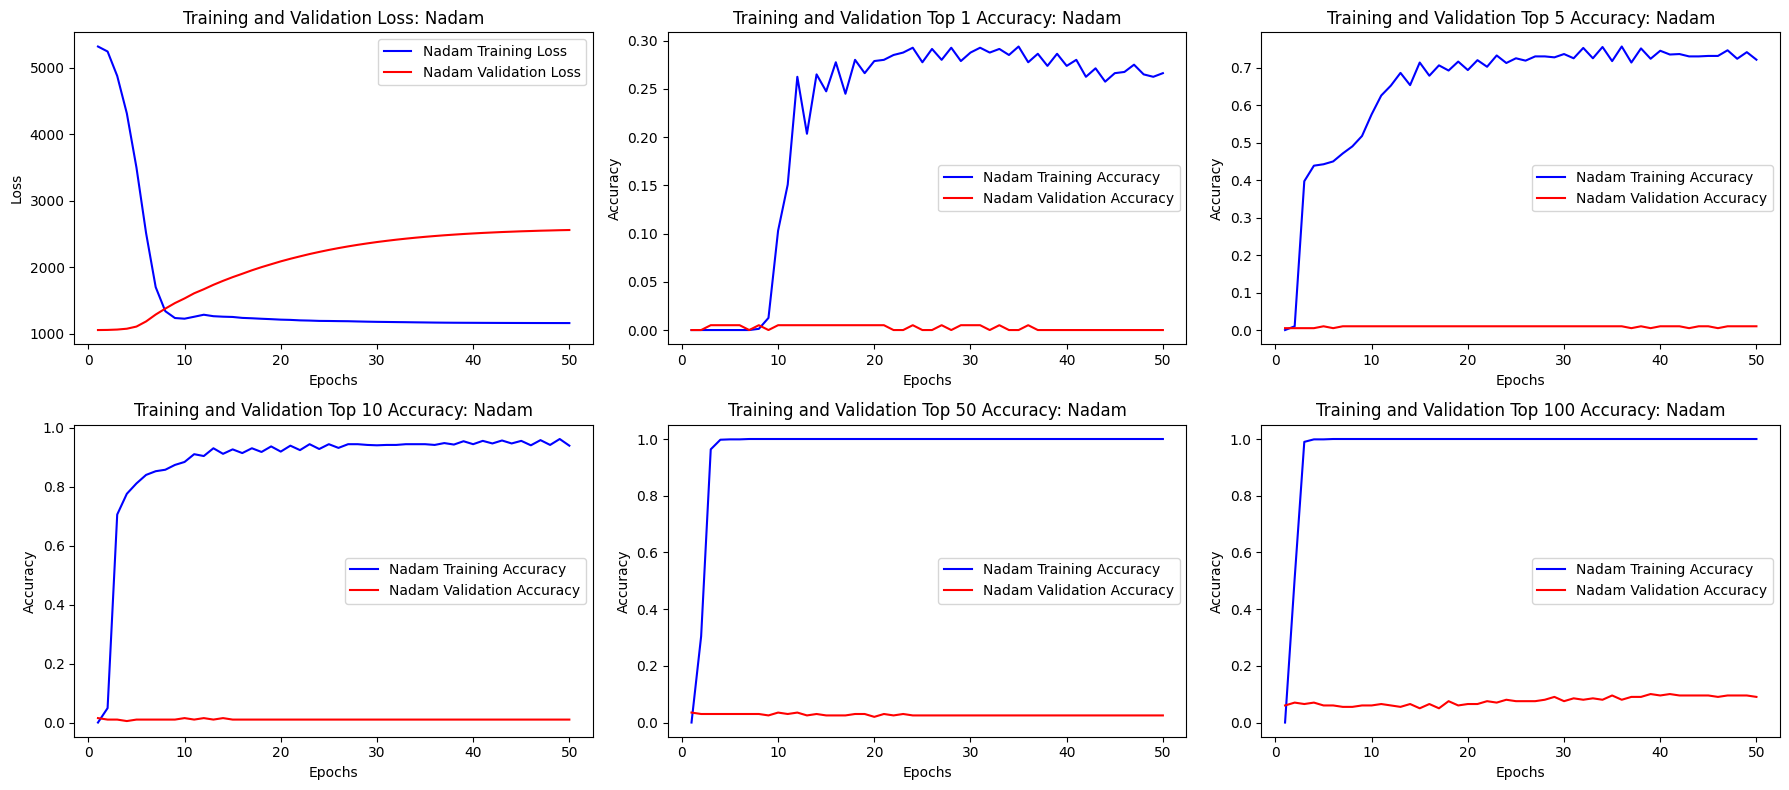

In [39]:
optimizer = tf.keras.optimizers.Nadam

plt.figure(figsize=(6*3, 4*2))

retrieval_model = RetrievalModel()
retrieval_model.compile(optimizer=optimizer(learning_rate=0.1))

history = retrieval_model.fit(cached_train, validation_data=cached_test, epochs=50, verbose=0)

# Retrieve the training metrics and validation metrics
train_loss = history.history['loss']
train_top_1 = history.history['factorized_top_k/top_1_categorical_accuracy']
train_top_5 = history.history['factorized_top_k/top_5_categorical_accuracy']
train_top_10 = history.history['factorized_top_k/top_10_categorical_accuracy']
train_top_50 = history.history['factorized_top_k/top_50_categorical_accuracy']
train_top_100 = history.history['factorized_top_k/top_100_categorical_accuracy']
val_loss    = history.history['val_loss']
val_top_1   = history.history['val_factorized_top_k/top_1_categorical_accuracy']
val_top_5   = history.history['val_factorized_top_k/top_5_categorical_accuracy']
val_top_10  = history.history['val_factorized_top_k/top_10_categorical_accuracy']
val_top_50  = history.history['val_factorized_top_k/top_50_categorical_accuracy']
val_top_100 = history.history['val_factorized_top_k/top_100_categorical_accuracy']

# Plotting the metrics
epochs = range(1, len(train_loss) + 1)

# Plotting the loss metrics
plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss, 'b', label=f'{optimizer().name} Training Loss')
plt.plot(epochs, val_loss, 'r', label=f'{optimizer().name} Validation Loss')
plt.title(f'Training and Validation Loss: {optimizer().name}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the accuracy metrics
plt.subplot(2, 3, 2)
plt.plot(epochs, train_top_1, 'b', label=f'{optimizer().name} Training Accuracy')
plt.plot(epochs, val_top_1, 'r', label=f'{optimizer().name} Validation Accuracy')
plt.title(f'Training and Validation Top 1 Accuracy: {optimizer().name}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the accuracy metrics
plt.subplot(2, 3, 3)
plt.plot(epochs, train_top_5, 'b', label=f'{optimizer().name} Training Accuracy')
plt.plot(epochs, val_top_5, 'r', label=f'{optimizer().name} Validation Accuracy')
plt.title(f'Training and Validation Top 5 Accuracy: {optimizer().name}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the accuracy metrics
plt.subplot(2, 3, 4)
plt.plot(epochs, train_top_10, 'b', label=f'{optimizer().name} Training Accuracy')
plt.plot(epochs, val_top_10, 'r', label=f'{optimizer().name} Validation Accuracy')
plt.title(f'Training and Validation Top 10 Accuracy: {optimizer().name}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the accuracy metrics
plt.subplot(2, 3, 5)
plt.plot(epochs, train_top_50, 'b', label=f'{optimizer().name} Training Accuracy')
plt.plot(epochs, val_top_50, 'r', label=f'{optimizer().name} Validation Accuracy')
plt.title(f'Training and Validation Top 50 Accuracy: {optimizer().name}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the accuracy metrics
plt.subplot(2, 3, 6)
plt.plot(epochs, train_top_100, 'b', label=f'{optimizer().name} Training Accuracy')
plt.plot(epochs, val_top_100, 'r', label=f'{optimizer().name} Validation Accuracy')
plt.title(f'Training and Validation Top 100 Accuracy: {optimizer().name}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [40]:
retrieval_model = RetrievalModel()
retrieval_model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.1))
retrieval_model.fit(cached_train, epochs=20, verbose=0)
retrieval_model.evaluate(cached_test, return_dict=True)

1/1 [==============================] - 0s 335ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0050 - factorized_top_k/top_50_categorical_accuracy: 0.0402 - factorized_top_k/top_100_categorical_accuracy: 0.0955 - loss: 2024.7573 - regularization_loss: 0.0000e+00 - total_loss: 2024.7573


{'factorized_top_k/top_1_categorical_accuracy': 0.0,
 'factorized_top_k/top_5_categorical_accuracy': 0.0,
 'factorized_top_k/top_10_categorical_accuracy': 0.005025125574320555,
 'factorized_top_k/top_50_categorical_accuracy': 0.04020100459456444,
 'factorized_top_k/top_100_categorical_accuracy': 0.0954773873090744,
 'loss': 2024.75732421875,
 'regularization_loss': 0,
 'total_loss': 2024.75732421875}

Why test performance is bad:
- The model is re-recommending some events that the users' already rated. These can crowd out test movies out of top K recommendations.
    - In some cases, re-recommending past things is good.

### Making predictions

Now that we have a retrieval_model, we would like to be able to make predictions. We can use the `tfrs.layers.factorized_top_k.BruteForce` layer to do this.

In [41]:
user_id = random.choice(processed_df['user_id'])
processed_df.loc[processed_df['user_id']==user_id]

,user_id,user_rating,event_id,event_name,location,tags,interested,location_andir,location_bali,location_balikpapan,...,location_sukasari,location_sumbersari,location_surabaya,location_surakarta,location_tangerang,location_tegalsari,location_ubud,location_west_denpasar,location_west_semarang,location_yogyakarta
295,835,5,80,"Indonesia International Shipbilding,Offshore, ...",Jakarta,"Tradeshow, Railway & Roadways, Logistics & Tra...",167,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Note: make at least one inference before saving model.
This is done to make the model know which type of data it should be receiving.

In [42]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(retrieval_model.user_model, k=len(processed_df))
# recommends events out of the entire events dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((events.batch(100), events.batch(100).map(retrieval_model.event_model)))
)

# Get k recommendations. INPUT MUST HAVE AT LEAST K ITEMS
key, titles = index(tf.constant([user_id]))
print(f"Recommendations for user {user_id}: {[str(i.numpy()) for i in titles[0, :]]}")

Recommendations for user 835: ['80', '80', '80', '80', '72', '72', '397', '397', '397', '397', '81', '81', '81', '368', '368', '368', '368', '277', '277', '277', '277', '277', '249', '249', '43', '43', '43', '43', '312', '101', '101', '101', '217', '217', '217', '42', '94', '94', '303', '303', '288', '288', '288', '288', '67', '369', '194', '194', '194', '194', '194', '194', '194', '365', '365', '346', '346', '346', '346', '393', '64', '64', '64', '64', '64', '64', '68', '68', '68', '68', '1', '1', '321', '321', '321', '77', '77', '77', '292', '292', '292', '82', '82', '245', '188', '188', '188', '188', '152', '152', '240', '240', '147', '113', '113', '113', '309', '309', '309', '309', '241', '241', '241', '241', '241', '241', '357', '357', '357', '49', '257', '257', '257', '187', '187', '187', '187', '187', '353', '212', '212', '60', '60', '60', '60', '60', '394', '394', '394', '164', '164', '398', '398', '398', '398', '398', '398', '378', '378', '378', '172', '172', '172', '172', '17

## Ranking Model

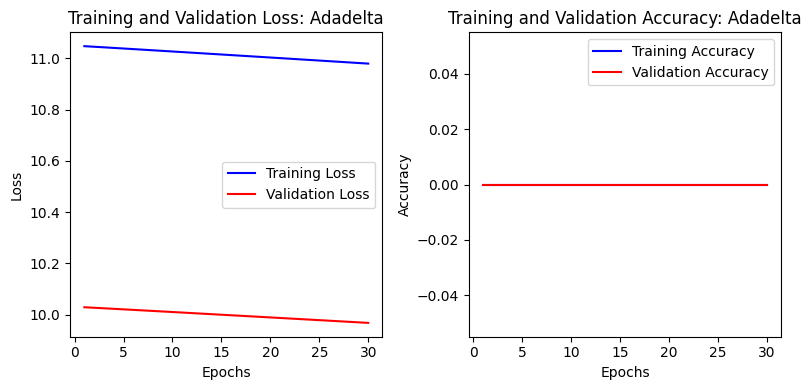

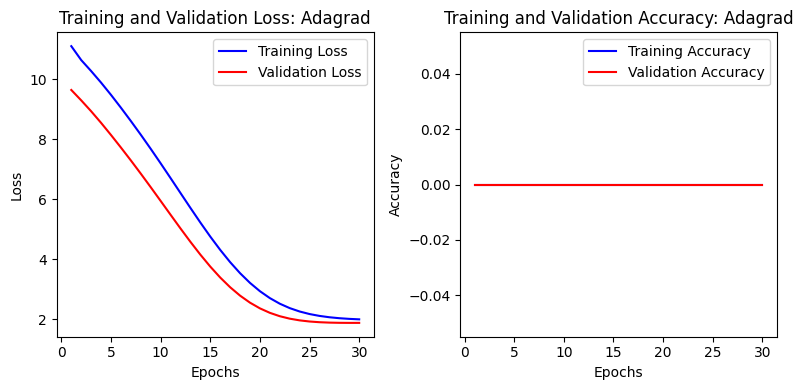

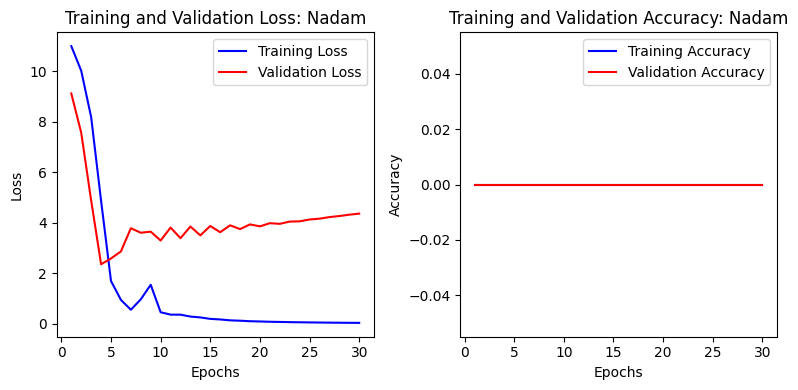

In [43]:
optimizers = [
        tf.keras.optimizers.Adadelta,
        tf.keras.optimizers.Adagrad,
        tf.keras.optimizers.Nadam,
    ]
for optimizer in optimizers:
    ranking_model = EventModel()
    ranking_model.compile(optimizer=optimizer(learning_rate=0.01))
    history = ranking_model.fit(cached_train, validation_data=cached_test, epochs=30, verbose=0)

    # Retrieve the training metrics and validation metrics
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Plotting the metrics
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 4))

    # Plotting the loss metrics
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(f'Training and Validation Loss: {optimizer().name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting the accuracy metrics
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy: {optimizer().name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()

### Choose learning rate

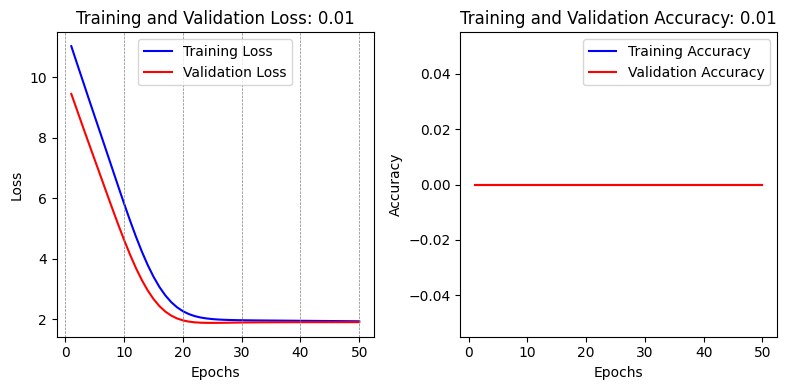

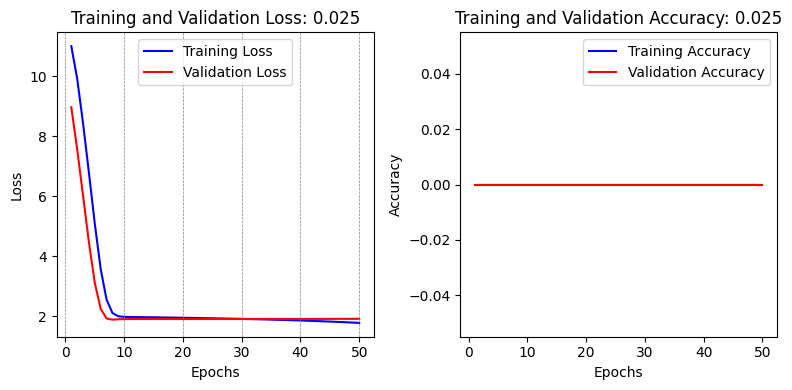

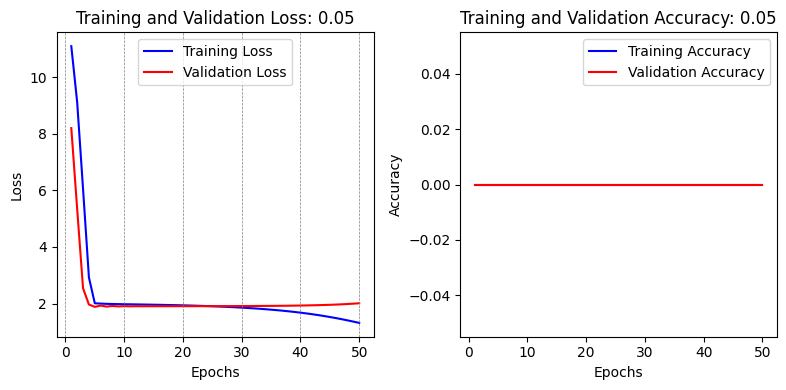

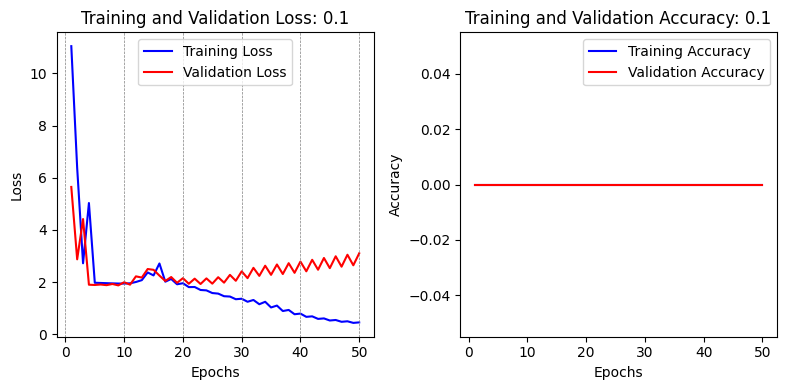

In [44]:
learning_rates = sorted([0.01,0.025,0.05,0.1])
for lr in learning_rates:
    ranking_model = EventModel()
    ranking_model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=lr))
    history = ranking_model.fit(cached_train, validation_data=cached_test, epochs=50, verbose=0)

    # Retrieve the training metrics and validation metrics
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Plotting the metrics
    epochs = range(1, len(train_loss) + 1)
    lines = ([0] + list(epochs))[::int(len(train_loss)/5)]

    plt.figure(figsize=(12, 4))

    # Plotting the loss metrics
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(f'Training and Validation Loss: {lr}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(lines)
    [plt.axvline(x=epoch, color='gray', linestyle='--', linewidth=0.5) for epoch in lines]
    plt.legend()

    # Plotting the accuracy metrics
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy: {lr}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()

# Finalize model

In [45]:
lr = 0.025
epochs = 10
ranking_model = EventModel()
ranking_model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=lr))
ranking_model.fit(cached_train, validation_data=cached_test, epochs=epochs, verbose=0)
ranking_model.evaluate(cached_test, return_dict=True)

1/1 [==============================] - 0s 49ms/step - root_mean_squared_error: 1.3766 - accuracy: 0.0000e+00 - loss: 1.8950 - regularization_loss: 0.0000e+00 - total_loss: 1.8950


{'root_mean_squared_error': 1.3765854835510254,
 'accuracy': 0.0,
 'loss': 1.8949875831604004,
 'regularization_loss': 0,
 'total_loss': 1.8949875831604004}

In [46]:
user_id = random.choice(processed_df['user_id'])
processed_df.loc[processed_df['user_id']==user_id]

,user_id,user_rating,event_id,event_name,location,tags,interested,location_andir,location_bali,location_balikpapan,...,location_sukasari,location_sumbersari,location_surabaya,location_surakarta,location_tangerang,location_tegalsari,location_ubud,location_west_denpasar,location_west_semarang,location_yogyakarta
789,806,4,224,I stop,Jakarta,"Tradeshow, Electric & Electronics, Industrial ...",1,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [47]:
test_ratings = {}
test_event_ids = np.unique(processed_df['event_id'])
for event_id in test_event_ids:
  test_ratings[event_id] = ranking_model({
      "user_id": np.array([user_id]),
      "event_id": np.array([event_id])
  })
[('event_id','score')]+[(i,float(j)) for (i,j) in sorted(test_ratings.items(), key=lambda x: x[1][0][0], reverse=True)]

[('event_id', 'score'),
 (228, 3.0528738498687744),
 (38, 3.045618772506714),
 (12, 3.033717155456543),
 (294, 3.029971122741699),
 (299, 3.0294015407562256),
 (380, 3.0213654041290283),
 (358, 3.020916700363159),
 (9, 3.0204286575317383),
 (49, 3.004283905029297),
 (397, 3.0041022300720215),
 (162, 3.0038962364196777),
 (159, 3.002962112426758),
 (167, 3.000370502471924),
 (241, 2.9996304512023926),
 (8, 2.9994194507598877),
 (261, 2.9981119632720947),
 (285, 2.997657060623169),
 (64, 2.997528314590454),
 (14, 2.9966886043548584),
 (100, 2.9964869022369385),
 (307, 2.9962611198425293),
 (133, 2.993791341781616),
 (57, 2.9927632808685303),
 (320, 2.9927024841308594),
 (111, 2.9925122261047363),
 (174, 2.991403818130493),
 (204, 2.9906270503997803),
 (28, 2.9902548789978027),
 (344, 2.989400863647461),
 (169, 2.989159107208252),
 (205, 2.988339424133301),
 (25, 2.9878149032592773),
 (156, 2.9875850677490234),
 (301, 2.9874579906463623),
 (99, 2.987218141555786),
 (296, 2.986587762832641

# Model Serving

## Retrieval Model

After the model is trained, we need a way to deploy it.

In a two-tower retrieval model, serving has two components:

- a serving query model, taking in features of the query and transforming them into a query embedding, and
- a serving candidate model. This most often takes the form of an approximate nearest neighbours (ANN) index which allows fast approximate lookup of candidates in response to a query produced by the query model.

In [48]:
user_id = random.choice(processed_df['user_id'])
processed_df.loc[processed_df['user_id']==user_id]

,user_id,user_rating,event_id,event_name,location,tags,interested,location_andir,location_bali,location_balikpapan,...,location_sukasari,location_sumbersari,location_surabaya,location_surakarta,location_tangerang,location_tegalsari,location_ubud,location_west_denpasar,location_west_semarang,location_yogyakarta
353,805,2,246,Mega Build Indonesia (MBI),Jakarta,"Tradeshow, Building & Construction, Furnishing...",453,False,False,False,...,False,False,False,False,False,False,False,False,False,False
608,805,3,201,ICCIM : The Third International Conference of ...,Jakarta,"Conference, Building & Construction, Civil Eng...",0,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [49]:
# path = os.path.join(tmp, "model")
path = "./retrieval_model"

# Save the index.
tf.saved_model.save(index, path)

# Load it back; can also be done in TensorFlow Serving.
loaded = tf.saved_model.load(path)

# Pass a user id in, get top predicted event titles back.
scores, titles = loaded([user_id])

INFO:tensorflow:Assets written to: ./retrieval_model\assets


INFO:tensorflow:Assets written to: ./retrieval_model\assets


## Ranking Model

In [50]:
path = "./ranking_model"
tf.saved_model.save(ranking_model, path)
loaded = tf.saved_model.load(path)

test_ratings = {}
test_event_ids = [random.randint(1,event_count+1) for i in range(1000)]
for event_id in test_event_ids:
  test_ratings[event_id] = loaded.ranking_model((
    tf.constant([user_id], dtype=tf.int64),
    tf.constant([event_id], dtype=tf.int64)
    ))

print("Ratings Desc:")
for id, score in itertools.islice(sorted(test_ratings.items(), key=lambda x: x[1][0][0], reverse=True),10):
  title = id
  print(f"{title}: {score[0][0]}")

print()

print("Ratings Asc:")
for id, score in itertools.islice(sorted(test_ratings.items(), key=lambda x: x[1][0][0]),10):
  title = id
  print(f"{title}: {score[0][0]}")

INFO:tensorflow:Assets written to: ./ranking_model\assets


INFO:tensorflow:Assets written to: ./ranking_model\assets


Ratings Desc:
228: 3.107168674468994
38: 3.0950284004211426
294: 3.0798254013061523
299: 3.077460765838623
380: 3.0770974159240723
358: 3.074711799621582
9: 3.068241834640503
159: 3.061326265335083
49: 3.054859161376953
167: 3.0543532371520996

Ratings Asc:
161: 2.9039173126220703
4: 2.908921718597412
56: 2.9092812538146973
126: 2.9122962951660156
208: 2.9127578735351562
306: 2.9149184226989746
390: 2.915475368499756
68: 2.9155988693237305
236: 2.918027400970459
206: 2.9208357334136963
